# Non Linear Regression

In [8]:
from pymc3 import sample, Normal, HalfNormal, Uniform, model, plot_posterior, sample_posterior_predictive, traceplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as optimize
import arviz as az
import pymc3 as pm

In [42]:
def damped_osc(a,b, t):
    f = np.exp(a*t)*(np.cos(b*t)-(a/b)*np.sin(b*t))
    return f

Text(0, 0.5, 'displacement /m')

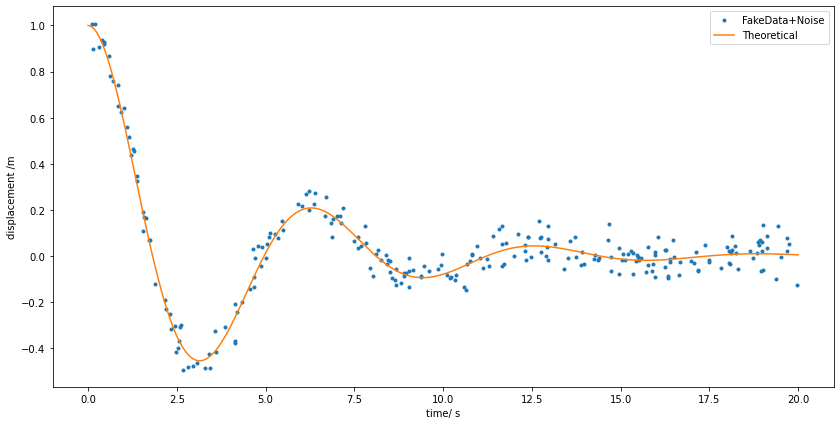

In [91]:
# initial conditions
alpha,beta=-0.25,1

# theoretical result
time=np.linspace(0,20,250)
F_theory=damped_osc(alpha,beta,time)

#artificial data and noise
time_data=np.random.rand(250)*20
time_data.sort()
sigma_noise=0.05 # standard deviation
F_data=damped_osc(alpha,beta,time_data)
F_data=np.random.normal(F_data,scale=sigma_noise)
fig= plt.figure(figsize=(14,7))
plt.plot(time_data,F_data, '.', label='FakeData+Noise')
plt.plot(time, F_theory, '-', label='Theoretical')
plt.legend()
plt.xlabel('time/ s')
plt.ylabel('displacement /m')

# The Bayesian part

In [46]:
with pm.Model() as non_linear:
    #priors for cooling coefficient and estimated standard deviation of the error
    alpha = pm.Uniform('alpha', -5, 5)  
    beta=pm.Uniform('beta',-5,5)
    epsilon = pm.HalfNormal('epsilon', sigma=5)
    #likelihood
    F_pred = pm.Normal('F_pred', mu=damped_osc(alpha, beta, time_data), sd=epsilon, observed=F_data)  # bringing it all together
    # Explore and Sample the Parameter Space
    trace = pm.sample(2000, tune=1000,cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 29 seconds.


In [48]:
az.summary(trace)

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.256,0.006,-0.268,-0.245,0.0,0.0,4409.0,4386.0,4421.0,3165.0,1.0
beta,1.006,0.005,0.997,1.017,0.0,0.0,4674.0,4671.0,4680.0,2949.0,1.0
epsilon,0.054,0.003,0.050,0.059,0.0,0.0,4940.0,4895.0,4977.0,2828.0,1.0


alpha and beta closely match the real values, unlike frequentist approach this gives the standard deviation of the error, epsilon, characterising the noise in the model.

In [54]:
from pymc3 import sample_posterior_predictive

chain_count =  trace.get_values('alpha').shape[0]
F_pred = sample_posterior_predictive(trace, samples=chain_count, model=non_linear)
data_spp = az.from_pymc3(trace=trace, posterior_predictive=F_pred)

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


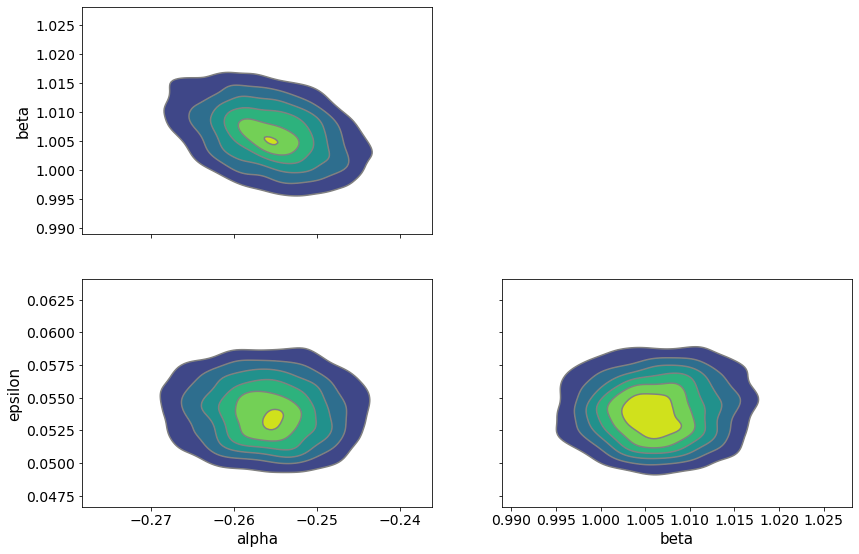

In [59]:
joint_plt = az.plot_pair(data_spp, var_names=['alpha', 'beta', 'epsilon'], kind='kde', fill_last=False);

Using the code above we can generate a joint plot by sampling from the posterior P(alpha,beta,epsilon|data)

We can also get a trace plot to verify the sampling didn't get stuck and that the sampling explored the parameter space sufficiently. 

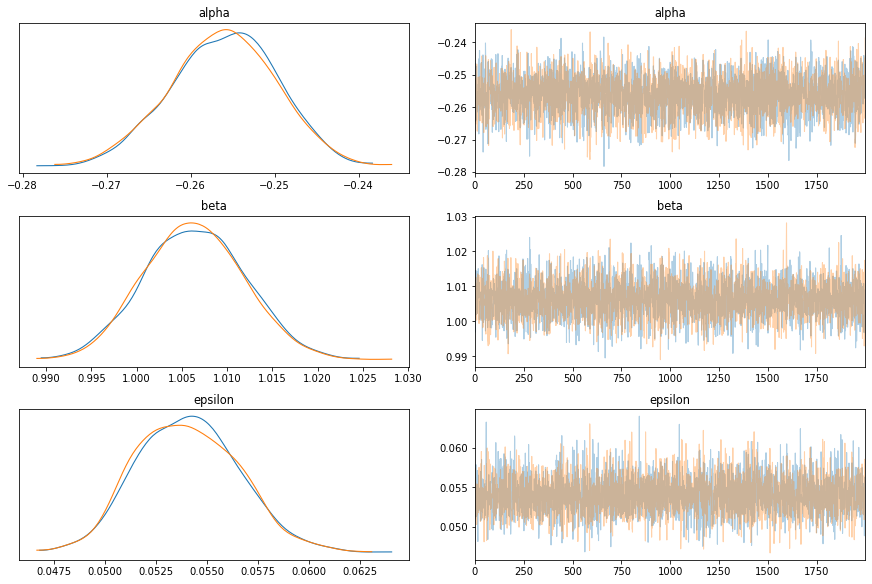

In [62]:
trace_fig = az.plot_trace(trace,var_names=[ 'alpha', 'beta','epsilon'],figsize=(12, 8));

We can also get the highest posterior density (HPD) for our parameters by using the following method, here we selected 99%.

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\arviz\utils.py:653: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


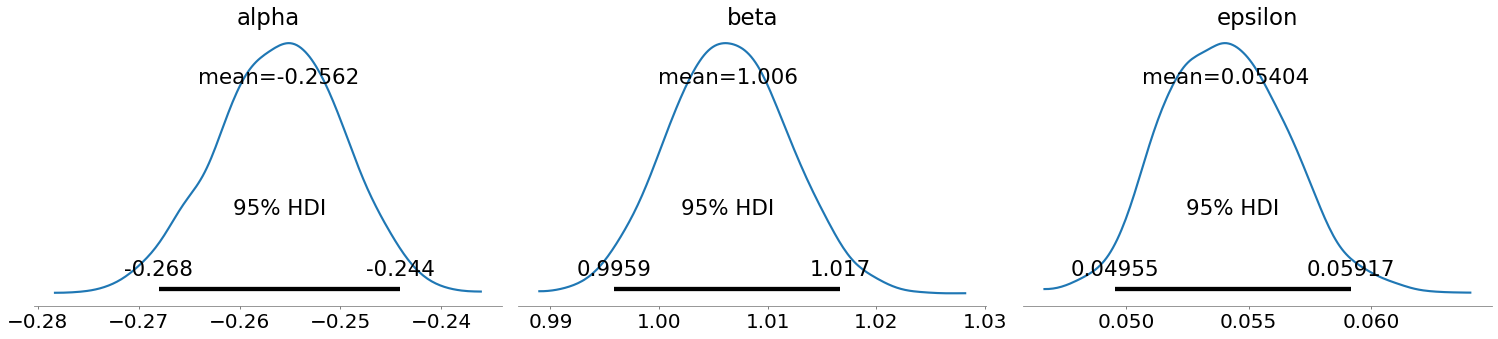

In [64]:
from pymc3 import plot_posterior

posterior_params = plot_posterior(data_spp,
                                     point_estimate='mean',
                                     credible_interval=0.95,
                                     textsize=20,
                                     round_to=4);

If there was no noise, our mean values would perfectly be equal to the “unknown” parameters. Since there is noise, just like real data, there is uncertainty in the values of our parameters and we need to quantify the uncertainty in them.

From part 1, the real values of alpha, beta and the noise distribution sigma were -0.25, 1 and 0.05. Not only are the mean posteriors close to these values, but the HPD easily envelops the real values, exactly what we wanted.

One of the benefits of Bayesian inference is that besides calculating the mean values of our parameters, we also get distributions for our parameters as shown above. 

sampling from our distribution is done above in the sample_posterior, and below for clarity, with the method sample_posterior_predictive()

Calculating uncertainty in our model from not only the parameters but also the data was done by sampling from our posterior. 

Generating quantiles from our posterior predictions is also simple using the percentile method in NumPy.

In [78]:
crit_l = np.percentile(F_pred["F_pred"],q=95,axis=0)  # grab lower 2.5% quantiles
crit_u = np.percentile(F_pred["F_pred"],q=5,axis=0)  # grab Upper 92.5% quantiles
mean_spp = np.mean(F_pred["F_pred"], axis=0) # Median

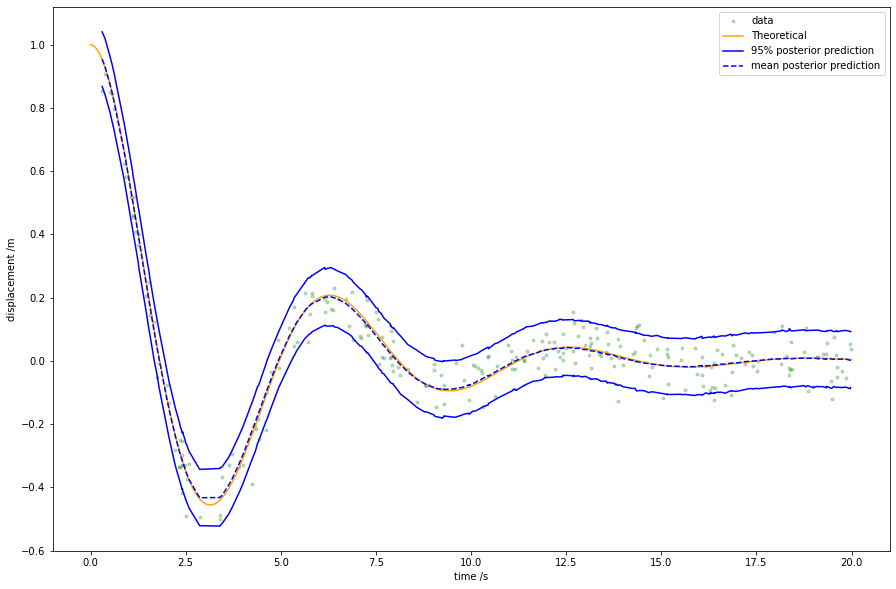

In [89]:
fig= plt.figure(figsize=(15,10))
plt.plot(time_data,F_data,'.', c='green', label='data', alpha=0.25)
plt.plot(time, F_theory, '-',c='orange', label='Theoretical')
plt.plot(time_data,crit_l,'-',c='blue', label='95% posterior prediction')
plt.plot(time_data,crit_u,'-',c='blue' )
plt.plot(time_data,mean_spp, '--', c='blue', label='mean posterior prediction')
plt.xlabel('time /s')
plt.ylabel('displacement /m')
plt.legend()